In [6]:
# !pip install bs4 lxml pandas numpy requests
# !pip install yfinance
# !pip install yahoofinancials

## Importing libraries

In [130]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import yfinance as yf
# from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings("ignore")

## Collecting stock news data from Market Insider

In [ ]:
columns = ['datetime','ticker','source', 'title' ]
df = pd.DataFrame(columns=columns)

#https://markets.businessinsider.com/news/nvda-stock?p={page} ->> Nvidia stock news
#https://markets.businessinsider.com/news/amzn-stock?p={page} ->> Amazon stock news
#https://markets.businessinsider.com/news/tsla-stock?p={page} ->> Tesla stock news
#https://markets.businessinsider.com/news/googl-stock?p={page} ->> Google stock news
#https://markets.businessinsider.com/news/adbe-stock?p={page} ->> Adobe stock news
#https://markets.businessinsider.com/news/axp-stock?p={page} ->> American Express stock news
#https://markets.businessinsider.com/news/meta-stock?p={page} ->> Meta stock news
#https://markets.businessinsider.com/news/spot-stock?p={page} ->> Spotify stock news
#https://markets.businessinsider.com/news/msft-stock?p={page} ->> Microsoft stock news
#https://markets.businessinsider.com/news/jpm-stock?p={page}  -->JPMorgan stock news

counter = 0
for page in range(1,200):
    url = f'https://markets.businessinsider.com/news/jpm-stock?p={page}'
    response = requests.get(url)
    html = response.text
    soup = BeautifulSoup (html, 'lxml')
    articles = soup.find_all('div', class_ = 'latest-news__story')
    for article in articles:
        datetime = article.find('time', class_ = 'latest-news__date').get('datetime')
        title = article.find('a', class_ = 'news-link').text
        source = article.find('span', class_ = 'latest-news__source').text
    #   link = article.find('a', class_ = 'news-link').get('href')
        ticker = 'JPM'       # 'AMZN', 'TSLA', 'GOOGL', 'ADBE', 'AXP', 'META', 'NVDA' ,'SPOT' ,'MSFT' ,'JPM'
        df = pd.concat([pd.DataFrame([[datetime,ticker, source,title]], columns=df.columns), df], ignore_index=True)
        counter += 1

print (f'{counter} headlines scraped from {page+1} pages')

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
print(df.shape)
df.head()

In [ ]:
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df.drop(columns=['datetime'], inplace=True)

In [ ]:
df.head()

In [ ]:
cols = df.columns.tolist()  #['source', 'title', 'top_sentiment', 'sentiment_score', 'date', 'time']
cols = cols[-2:] + cols[:-2]
print(cols)

In [ ]:
df = df[cols]
df.head(5)

In [ ]:
# df.to_csv('historical_nvidia_1.csv', index=False)
# df.to_csv('historical_tsla_1.csv', index=False)
# df.to_csv('historical_amazon_1.csv', index=False)
# df.to_csv('historical_Google_1.csv', index=False)
# df.to_csv('historical_adobe_1.csv', index=False)
# df.to_csv('historical_axp_1.csv', index=False)
# df.to_csv('historical_meta_1.csv', index=False)
# df.to_csv('historical_spotify_1.csv', index=False)
# df.to_csv('historical_microsoft_1.csv', index=False)
# df.to_csv('historical_jpmorgan_1.csv', index=False)

# Combining all stocks in one  csv file

In [ ]:
all_csv_files = ['historical_nvidia_1.csv', 'historical_amazon_1.csv', 'historical_tsla_1.csv','historical_axp_1.csv','historical_Google_1.csv','historical_adobe_1.csv','historical_meta_1.csv','historical_spotify_1.csv','historical_microsoft_1.csv','historical_jpmorgan_1.csv']

combined_stock_news = pd.concat([pd.read_csv(file) for file in all_csv_files ], ignore_index=True)

combined_stock_news

In [ ]:
combined_stock_news.to_csv('combined_stock_news_1.csv')

In [ ]:
combined_stock_news = pd.read_csv('combined_stock_news_1.csv')
combined_stock_news.drop(columns=['time', 'source'],index=0, inplace=True)

### Aggregating stock news by date and ticker

In [ ]:
combined_stock_news =  combined_stock_news.groupby(['date','ticker'])['title'].apply(' '.join).reset_index()

In [ ]:
combined_stock_news

### Fetching stock prices corresponding to each date

In [ ]:
def fetch_stock_prices(ticker, date):
    stock = yf.Ticker(ticker)
    start_date = pd.to_datetime(date)
    end_date = start_date + pd.Timedelta(days=1)

    hist = stock.history(start=start_date, end=end_date)

    if not hist.empty:
        open_price = hist['Open'][0]
        high_price = hist['High'][0]
        low_price = hist['Low'][0]
        close_price = hist['Close'][0]
        return open_price, high_price, low_price, close_price
    else:
        return None, None, None, None

In [ ]:
price_data = combined_stock_news.apply(lambda row: fetch_stock_prices(row['ticker'], row['date']), axis=1)
combined_stock_news[['open', 'high', 'low', 'close']] = pd.DataFrame(price_data.tolist(), index=combined_stock_news.index)

In [ ]:
combined_stock_news.isnull().value_counts()

In [ ]:
combined_stock_news = combined_stock_news.dropna(subset=['open', 'high', 'low', 'close']).reset_index()

In [ ]:
# combined_stock_news

In [ ]:
combined_stock_news.to_csv('combined_with_price.csv')

In [2]:
stock_news = pd.read_csv('/kaggle/input/stock-news-sentiment-analysis/combined_with_price.csv',usecols=['date', 'ticker', 'title', 'open', 'high', 'low', 'close'])

# Sort by ticker and date to ensure proper time series order
stock_news= stock_news.sort_values(by=['ticker', 'date']).reset_index(drop=True)

### Calulating the price movement

In [3]:

time_horizon = 1 

# Calculate the future closing price
stock_news['future_close'] = stock_news.groupby('ticker')['close'].shift(-time_horizon)

# Calculate the price movement as a percentage
stock_news['price_movement'] = ((stock_news['future_close']-stock_news['close']) / stock_news['close']) * 100

# Drop rows where future_close is NaN (i.e., where we don't have enough data to calculate the movement)
stock_news = stock_news.dropna(subset=['future_close'])

In [34]:
increase_threshold = 0.75
decrease_threshold = -0.75

def label_movement(movement):
    if movement >= increase_threshold:       # 1->increase, 0->no change, -1->decrease            
        return 1    
    elif movement <= decrease_threshold:
        return -1
    else:
        return 0

stock_news['movement_label'] = stock_news['price_movement'].apply(label_movement)

### Preprocessing the Textual data

In [12]:
#  !pip install nltk spacy gensim

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import brown
from tqdm.notebook import tqdm
import spacy

from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# text preprocessing function

def preprocess_text(text):
        
        text = text.lower()
        
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'[^\w\s]', '', text)

        tokens = word_tokenize(text)

        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
       
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]


#         lemmatizer = WordNetLemmatizer()
#         tokens = [lemmatizer.lemmatize(word) for word in tokens]

        return ' '.join(tokens)

stock_news['preprocessed_text'] = stock_news['title'].apply(preprocess_text)

In [17]:
stock_news.head()

,date,ticker,title,open,high,low,close,future_close,price_movement,movement_label,preprocessed_text
0,2012-12-20,ADBE,Adobe acquires social media firm Behance as it...,38.080002,38.160000,37.790001,37.869999,43.360001,14.496968,1,adob acquir social media firm behanc expand cloud
1,2013-06-18,ADBE,Adobe Systems profit beats as Creative Cloud s...,43.549999,44.200001,43.220001,43.360001,45.779999,5.581177,1,adob system profit beat creativ cloud subscrip...
2,2013-06-19,ADBE,Adobe expects third-quarter Creative Cloud sub...,46.430000,46.439999,45.349998,45.779999,54.860001,19.833993,1,adob expect thirdquart creativ cloud subscrib ...
3,2013-10-29,ADBE,Adobe data breach more extensive than previous...,54.000000,55.119999,53.910000,54.860001,68.519997,24.899737,1,adob data breach extens previous disclos
4,2014-03-18,ADBE,Adobe results beat estimates as web-based subs...,67.660004,70.239998,67.519997,68.519997,70.730003,3.225346,1,adob result beat estim webbas subscript rise


In [35]:
stock_news['movement_label'].value_counts()

movement_label
 1    4032
 0    3619
-1    3369
Name: count, dtype: int64

## Sentiment Analysis

In [57]:
# !pip install scikit-learn
# !pip install -U textblob
# !python -m textblob.download_corpora
# !pip install scipy==1.12

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob

In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Using Finbert for Sentiment Analysis

In [38]:
# !pip install transformers torch

In [83]:
import pandas as pd
import torch
import scipy
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from transformers import BertTokenizer, BertModel

In [84]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
def get_finbert_sentiment(text):
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 513}
    
    tokenized_text = tokenizer(text, **tokenizer_kwargs)
    sentiment_analysis = pipeline("sentiment-analysis", model="ProsusAI/finbert" ,tokenizer=tokenizer)
    sentiment_result = sentiment_analysis(text)
    
    # Extract sentiment label and score
    if sentiment_result:
        sentiment_label = sentiment_result[0]['label']
        sentiment_score = sentiment_result[0]['score']
        
        # Convert sentiment label to numeric value
        if sentiment_label == 'negative':
            return -1 * sentiment_score
        elif sentiment_label == 'positive':
            return sentiment_score
        else:
            return 0
    else:
        return 0

# Example usage with pandas DataFrame 'data'
stock_news['finbert_sentiment_score'] = stock_news['preprocessed_text'].apply(get_finbert_sentiment)

# Drop the intermediate column used for sentiment analysis
data = data.drop(['finbert_sentiment'], axis=1)

In [92]:
stock_news.head(10)

,date,ticker,title,open,high,low,close,future_close,price_movement,movement_label,preprocessed_text,vader_neg,vader_neu,vader_pos,vader_compound,vader_prediction,finbert_sentiment,finbert_sentiment_score
0,2012-12-20,ADBE,Adobe acquires social media firm Behance as it...,38.080002,38.160000,37.790001,37.869999,43.360001,14.496968,1,adob acquir social media firm behanc expand cloud,0.000,0.753,0.247,0.3182,1,neutral,-0.182500
1,2013-06-18,ADBE,Adobe Systems profit beats as Creative Cloud s...,43.549999,44.200001,43.220001,43.360001,45.779999,5.581177,1,adob system profit beat creativ cloud subscrip...,0.000,0.707,0.293,0.4404,1,positive,-0.745440
2,2013-06-19,ADBE,Adobe expects third-quarter Creative Cloud sub...,46.430000,46.439999,45.349998,45.779999,54.860001,19.833993,1,adob expect thirdquart creativ cloud subscrib ...,0.000,1.000,0.000,0.0000,0,positive,-0.472406
3,2013-10-29,ADBE,Adobe data breach more extensive than previous...,54.000000,55.119999,53.910000,54.860001,68.519997,24.899737,1,adob data breach extens previous disclos,0.000,1.000,0.000,0.0000,0,negative,0.865052
4,2014-03-18,ADBE,Adobe results beat estimates as web-based subs...,67.660004,70.239998,67.519997,68.519997,70.730003,3.225346,1,adob result beat estim webbas subscript rise,0.000,1.000,0.000,0.0000,0,neutral,-0.121117
5,2014-09-16,ADBE,Adobe revenue misses estimate,70.010002,70.959999,69.190002,70.730003,69.989998,-1.046240,-1,adob revenu miss estim,0.348,0.652,0.000,-0.1531,0,neutral,-0.086436
6,2015-01-14,ADBE,Adobe plans up to $2 billion share buyback Ado...,69.879997,70.400002,68.980003,69.989998,79.940002,14.216324,1,adob plan billion share buyback adob plan bill...,0.000,0.645,0.355,0.5267,1,neutral,-0.004149
7,2015-06-16,ADBE,Adobe revenue rises 8.8 percent,78.930000,80.430000,78.830002,79.940002,83.620003,4.603453,1,adob revenu rise percent,0.000,1.000,0.000,0.0000,0,neutral,-0.234527
8,2015-08-10,ADBE,Adobe joins tech industry push in raising mate...,83.389999,83.919998,83.190002,83.620003,80.309998,-3.958389,-1,adob join tech industri push rais matern paren...,0.000,0.784,0.216,0.2960,1,neutral,-0.061586
9,2015-09-17,ADBE,Adobe revenue beats on higher-than-expected su...,80.449997,81.879997,79.699997,80.309998,91.459999,13.883703,1,adob revenu beat higherthanexpect subcript,0.000,1.000,0.000,0.0000,0,positive,-0.800565


In [27]:
stock_news.to_csv('stock_news_finbert.csv')

### Using vader for sentiment analysis

In [52]:
def apply_vader_sentiment(df, text_column):

    analyzer = SentimentIntensityAnalyzer()

    def get_vader_sentiment(text):
        scores = analyzer.polarity_scores(text)
        return scores['neg'], scores['neu'], scores['pos'], scores['compound']

    vader_sentiments = df[text_column].apply(get_vader_sentiment)
    df['vader_neg'] = vader_sentiments.apply(lambda x: x[0])
    df['vader_neu'] = vader_sentiments.apply(lambda x: x[1])
    df['vader_pos'] = vader_sentiments.apply(lambda x: x[2])
    df['vader_compound'] = vader_sentiments.apply(lambda x: x[3])

    # Generating Trading Signals
    def classify_sentiment(compound_score):
        if compound_score >= 0.1:
            return 1
        elif compound_score <= -0.1:
            return -1
        else :
            return 0

    df['Trading_Signal'] = df['vader_compound'].apply(classify_sentiment)

    return df

stock_pre_processed_news = apply_vader_sentiment(stock_news, 'preprocessed_text')

In [109]:
stock_pre_processed_news = stock_news
stock_pre_processed_news.head()

,date,ticker,title,open,high,low,close,future_close,price_movement,movement_label,preprocessed_text,vader_neg,vader_neu,vader_pos,vader_compound,vader_prediction,finbert_sentiment,finbert_sentiment_score
0,2012-12-20,ADBE,Adobe acquires social media firm Behance as it...,38.080002,38.160000,37.790001,37.869999,43.360001,14.496968,1,adob acquir social media firm behanc expand cloud,0.0,0.753,0.247,0.3182,1,neutral,-0.182500
1,2013-06-18,ADBE,Adobe Systems profit beats as Creative Cloud s...,43.549999,44.200001,43.220001,43.360001,45.779999,5.581177,1,adob system profit beat creativ cloud subscrip...,0.0,0.707,0.293,0.4404,1,positive,-0.745440
2,2013-06-19,ADBE,Adobe expects third-quarter Creative Cloud sub...,46.430000,46.439999,45.349998,45.779999,54.860001,19.833993,1,adob expect thirdquart creativ cloud subscrib ...,0.0,1.000,0.000,0.0000,0,positive,-0.472406
3,2013-10-29,ADBE,Adobe data breach more extensive than previous...,54.000000,55.119999,53.910000,54.860001,68.519997,24.899737,1,adob data breach extens previous disclos,0.0,1.000,0.000,0.0000,0,negative,0.865052
4,2014-03-18,ADBE,Adobe results beat estimates as web-based subs...,67.660004,70.239998,67.519997,68.519997,70.730003,3.225346,1,adob result beat estim webbas subscript rise,0.0,1.000,0.000,0.0000,0,neutral,-0.121117


In [54]:
stock_pre_processed_news['vader_prediction'].value_counts()

vader_prediction
 1    6593
 0    2792
-1    1635
Name: count, dtype: int64

In [110]:
stock_pre_processed_news.to_csv('stock_sentiment_vader.csv')

### Model Fitting and Training

In [102]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score  

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [103]:
# splitting trian and test data
X_train,X_test,y_train,y_test = train_test_split(stock_pre_processed_news['preprocessed_text'],stock_pre_processed_news['movement_label'],test_size=0.2,random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape )

(8816,) (8816,)
(2204,) (2204,)


In [104]:
# BERT 

# class BERTEmbeddings:
#     def __init__(self, model_name='bert-base-uncased'):
#         self.tokenizer = BertTokenizer.from_pretrained(model_name)
#         self.model = BertModel.from_pretrained(model_name)

#     def preprocess(self, text):
#         # Tokenize the input text and get token IDs
#         inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
#         return inputs

#     def get_embeddings(self, text):
#         # Preprocess the text
#         inputs = self.preprocess(text)
#         with torch.no_grad():
#             outputs = self.model(**inputs)
#         # Get the embeddings for the [CLS] token
#         embeddings = outputs.last_hidden_state[:, 0, :].numpy()
#         return embeddings

#     def convert_text_column(self, text_column):
#         embeddings = []
#         for text in text_column:
#             embedding = self.get_embeddings(text)
#             embeddings.append(embedding)
#         return np.vstack(embeddings)

# # Example usage
# if __name__ == "__main__":
#     # Initialize BERT embeddings
#     bert_embedder = BERTEmbeddings()

#     # Convert the text column to BERT embeddings
#     X_train = bert_embedder.convert_text_column(X_train)
#     X_test = bert_embedder.convert_text_column(X_test)

### Feature Extraction using TF-IDF Vectorizer

In [105]:
# TF-IDF

tf_idf = TfidfVectorizer(ngram_range = (1,4),max_features= 10000,binary=True,
                         smooth_idf=False)

X_total = tf_idf.fit_transform(stock_pre_processed_news['preprocessed_text'])
y =stock_pre_processed_news['movement_label']
X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)

In [107]:
# Function to evaluate and plot ROC curves
# def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
#     print(y_pred_proba)
  
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred_proba)

#     print(f"{model_name} Classification Report:")
#     print(classification_report(y_test, y_pred))

#     # Ploting ROC curve
#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
#     plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

#     return accuracy, precision, recall, f1, roc_auc

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_pred_proba, average='weighted', multi_class='ovr')

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

#     Plotting ROC curve for each class
    classes = np.unique(y_test)
    y_test_binarized = label_binarize(y_test, classes=classes)

    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='best')
    plt.show()

    return accuracy, precision, recall, f1, roc_auc

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       0.40      0.33      0.36       672
           0       0.44      0.42      0.43       739
           1       0.42      0.49      0.45       793

    accuracy                           0.42      2204
   macro avg       0.42      0.41      0.41      2204
weighted avg       0.42      0.42      0.42      2204



<Figure size 1000x800 with 0 Axes>

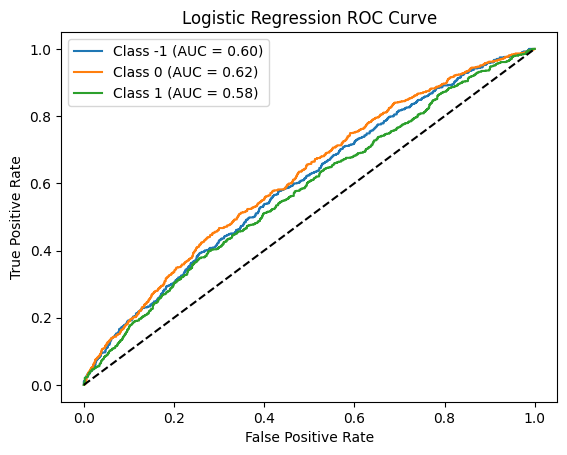

Logistic Regression - Accuracy: 0.42, Precision: 0.42, Recall: 0.42, F1-Score: 0.42, AUC: 0.60

SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.44      0.30      0.35       672
           0       0.46      0.42      0.44       739
           1       0.42      0.57      0.49       793

    accuracy                           0.44      2204
   macro avg       0.44      0.43      0.43      2204
weighted avg       0.44      0.44      0.43      2204



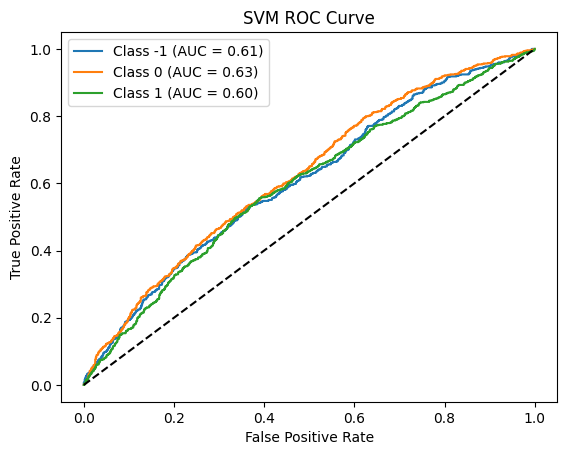

SVM - Accuracy: 0.44, Precision: 0.44, Recall: 0.44, F1-Score: 0.43, AUC: 0.61

KN Classification Report:
              precision    recall  f1-score   support

          -1       0.40      0.54      0.46       672
           0       0.40      0.37      0.39       739
           1       0.47      0.37      0.41       793

    accuracy                           0.42      2204
   macro avg       0.42      0.43      0.42      2204
weighted avg       0.43      0.42      0.42      2204



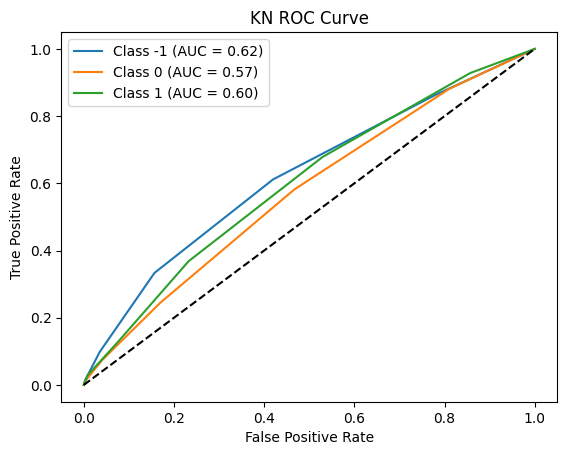

KN - Accuracy: 0.42, Precision: 0.43, Recall: 0.42, F1-Score: 0.42, AUC: 0.60



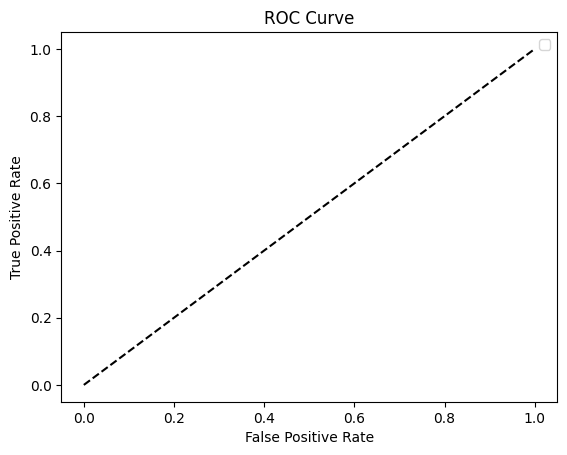

In [108]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
#     "Random Forest": RandomForestClassifier(),
#     "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
#     "Naive bayers" : MultinomialNB(alpha=1),
    'KN' : KNeighborsClassifier(),
#     'DT': DecisionTreeClassifier(max_depth=5),
#     'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=2),
#     'GBDT':GradientBoostingClassifier(n_estimators=50,random_state=2),
#     'xgb':XGBClassifier(n_estimators=50,random_state=2),
#     'cat':CatBoostClassifier(n_estimators=50,random_state=2)
}

# Evaluate each model and plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    accuracy, precision, recall, f1, roc_auc = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, AUC: {roc_auc:.2f}\n")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

,Unnamed: 0,Date,ticker,title,Open,High,Low,Close,future_close,price_movement,movement_label,preprocessed_text,vader_neg,vader_neu,vader_pos,sentiment,vader_prediction,finbert_sentiment,finbert_sentiment_score
741,742,2020-10-09,AMZN,7 Stocks You Can Buy to Help Save the Planet 9...,160.500000,164.449493,159.891495,164.332504,172.146500,4.754991,1,stock buy help save planet game stock wont hit...,0.018,0.644,0.338,0.9890,1,neutral,-0.088550
742,743,2020-10-12,AMZN,EU crafting Big Tech 'hit list' - FT Alibaba S...,167.496994,174.811996,166.977493,172.146500,172.181503,0.020334,0,eu craft big tech hit list ft alibaba stock em...,0.026,0.651,0.323,0.9826,1,neutral,-0.227566
743,744,2020-10-13,AMZN,Bank of America — A Sweet Place to Put Your Mo...,173.399506,174.619003,171.210999,172.181503,168.185501,-2.320808,-1,bank america sweet place put money fti consult...,0.000,0.769,0.231,0.9260,1,neutral,-0.068120
744,745,2020-10-14,AMZN,"After Double-Digit Fall, Is It Time for a Bull...",172.350006,173.244003,167.000000,168.185501,166.932495,-0.745014,0,doubledigit fall time bullish draftk stock bet...,0.077,0.691,0.232,0.9217,1,neutral,-0.015949
745,746,2020-10-15,AMZN,Pricey Plug Power Stock Could Keep Moving High...,164.600494,167.794006,164.000000,166.932495,163.635498,-1.975048,-1,pricey plug power stock could keep move higher...,0.000,0.769,0.231,0.9333,1,positive,-0.519457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,1658,2024-06-05,AMZN,Jefferies Reaffirms Their Buy Rating on Amazon...,180.100006,181.500000,178.750000,181.279999,185.000000,2.052075,1,jefferi reaffirm buy rate amazon amzn underval...,0.043,0.808,0.149,0.8176,1,neutral,-0.038039
1658,1659,2024-06-06,AMZN,Amazon Labor Union Formally Affiliates With Te...,181.750000,185.000000,181.490005,185.000000,184.300003,-0.378377,0,amazon labor union formal affili teamster unio...,0.000,0.729,0.271,0.8316,1,neutral,-0.009496
1659,1660,2024-06-07,AMZN,Cathie Wood-Led Ark Invest Buys $9.9M Worth Of...,184.899994,186.289993,183.360001,184.300003,187.059998,1.497555,1,cathi woodl ark invest buy worth amazon share ...,0.000,0.769,0.231,0.9571,1,neutral,-0.062323
1660,1661,2024-06-10,AMZN,Schwab Trading Activity Index rises slightly i...,184.070007,187.229996,183.789993,187.059998,187.229996,0.090879,0,schwab trade activ index rise slightli may wal...,0.108,0.676,0.216,0.9058,1,neutral,-0.102773
